In [2]:
%load_ext autoreload
%autoreload 2
import datasets
import llminference as L
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# TriviaQA

Notebook with basic information regarding the TriviaQA dataset.

In [3]:
triviaqa = datasets.load_dataset("trivia_qa", name="rc")
val = triviaqa["validation"]

Found cached dataset trivia_qa (/nethome/lukar/.cache/huggingface/datasets/trivia_qa/rc/1.2.0/ee76d8a9403e71177e2a3fa7e414d1ee28a79a0970d9176f62f268798aa64b31)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
adapter = L.Adapter.from_pretrained("EleutherAI/pythia-70m")

## TriviaQA stats

Context statistics for the questions in the validation dataset.

### Number of documents per question

In [5]:
num_docs = [len(x["title"]) for x in val["entity_pages"]]

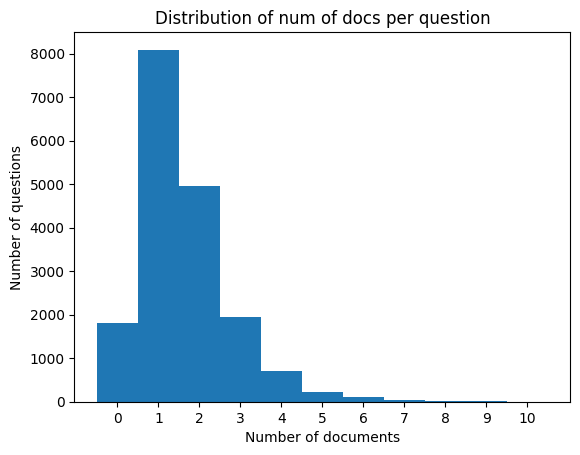

In [6]:
bins = np.arange(12) - 0.5
plt.hist(num_docs, bins=bins)
plt.xticks(bins[:-1] + 0.5)
plt.title("Distribution of num of docs per question")
plt.xlabel("Number of documents")
plt.ylabel("Number of questions")
plt.show()

### Document length (words)

In [7]:
doc_len_words = [len(ctx.split()) for x in val["entity_pages"] for ctx in x["wiki_context"]]

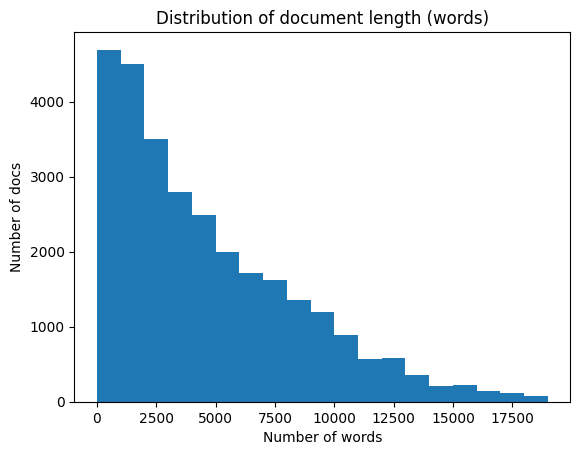

In [8]:
plt.hist(doc_len_words, bins = np.arange(20) * 1000)
plt.title("Distribution of document length (words)")
plt.xlabel("Number of words")
plt.ylabel("Number of docs")
plt.show()

### Document length (tokens)

In [9]:
def num_tokens(text):
    tokens = adapter.tokenizer(text, return_tensors="pt").input_ids
    return tokens.shape[1]

doc_len_toks = [num_tokens(ctx) for x in val["entity_pages"] for ctx in x["wiki_context"]]

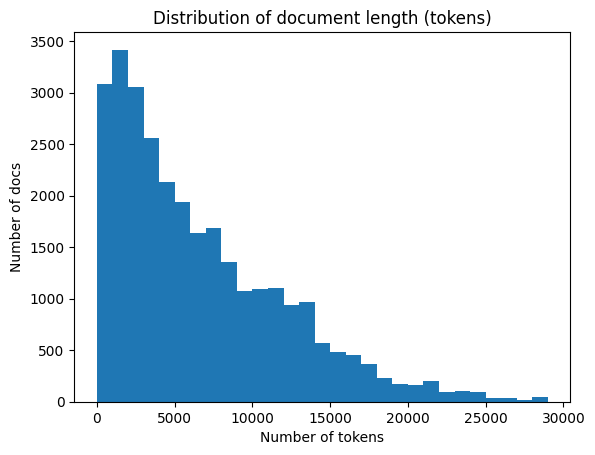

In [13]:
plt.hist(doc_len_toks, bins = np.arange(30) * 1000)
plt.title("Distribution of document length (tokens)")
plt.xlabel("Number of tokens")
plt.ylabel("Number of docs")
plt.show()

## Create TriviaQA subset

Find all questions with the specified **minimum** and **maximum** document length:

In [15]:
# Check if single document and is in required length range
def num_words(docs: dict) -> int:
    return len(docs["wiki_context"][0].split())


def num_tokens(docs: dict) -> int:
    tokens = adapter.tokenizer(docs["wiki_context"][0], return_tensors="pt")[
        "input_ids"
    ]
    return tokens.shape[1]


def condition(example: dict, min_length: int, max_length: int, count: str) -> bool:
    docs = example["entity_pages"]
    # Only return examples with *one* doc (otherwise should be sum of doc lenghts)
    if len(docs["title"]) != 1:
        return False
    if count == "words":
        len_doc = num_words(docs)
    elif count == "tokens":
        len_doc = num_tokens(docs)
    else:
        raise ValueError(f"count needs to be tokens or words, got {count}")
    return min_length < len_doc < max_length

#### First find docs with num_words < 2000

In [16]:
min_length = 0
max_length = 2000
val_filtered = val.filter(partial(condition, min_length=min_length, max_length=max_length, count="words"))

Filter:   0%|          | 0/17944 [00:00<?, ? examples/s]

In [17]:
val_filtered

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 2871
})

#### Now find documents with 1500 < num_tokens < 1950

In [18]:
min_length = 1500
max_length = 1950
val_2k = val_filtered.filter(partial(condition, min_length=min_length, max_length=max_length, count="tokens"))

Filter:   0%|          | 0/2871 [00:00<?, ? examples/s]

In [19]:
val_2k

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 445
})

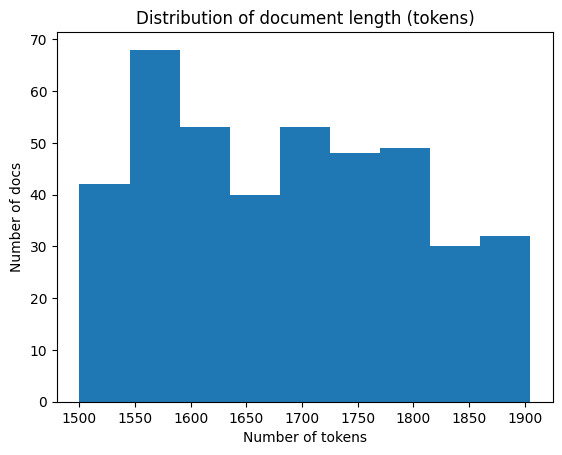

In [20]:
doc_len = [num_tokens(docs) for docs in val_2k["entity_pages"]]
plt.hist(doc_len, bins = min_length + (max_length - min_length) / 10 * np.arange(10))
plt.title("Distribution of document length (tokens)")
plt.xlabel("Number of tokens")
plt.ylabel("Number of docs")
plt.show()

#### Save to disk

In [21]:
# triviaqa_2k = datasets.DatasetDict({"validation": val_2k})
# triviaqa_2k.save_to_disk("/nethome/lukar/datasets/triviaqa_2k")

#### Load from disk

In [22]:
triviaqa_2k = datasets.load_from_disk("/nethome/lukar/datasets/triviaqa_2k")

In [23]:
triviaqa_2k

DatasetDict({
    validation: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 445
    })
})

#### Number of *unique* documents

In [27]:
titles = [example["entity_pages"]["title"][0] for example in triviaqa_2k["validation"]]

In [28]:
print(f"Number of *unique* titles: {len(set(titles))}")

Number of *unique* titles: 225
